In [ ]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [2]:
import open_clip
import torch

import requests

import numpy as np

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import itertools

import tqdm

import warnings
warnings.simplefilter("ignore")

In [3]:
# Загрузка модели OpenCLIP со свёрточной ResNet 50
model, preprocess = open_clip.create_model_from_pretrained('hf-hub:thaottn/OpenCLIP-resnet50-CC12M')
tokenizer = open_clip.get_tokenizer('hf-hub:thaottn/OpenCLIP-resnet50-CC12M')

In [48]:
# Выгрузка изображение
url = "https://static.wikia.nocookie.net/pokemon/images/4/4a/0025Pikachu.png/revision/latest?cb=20240714164133"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; rv:45.0)"}

response = requests.get(url, stream=True, headers=headers).raw

In [49]:
# Определение классов
img = Image.open(response)
classes = ["pikachu", "not pikachu"]

In [6]:
# Определение функции для классифиации изображений
def get_distribution(image, classes):

    image = preprocess(image).unsqueeze(0)
    text = tokenizer(classes)

    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    return text_probs[0].numpy()

# Поворот изображения. 3.1

In [7]:
# Создание словарей для хранения данных
deg_probs_dict = {}
deg_img_dict = {}

In [8]:
# Ротация и классификация изображений
for deg in tqdm.tqdm(range(-90, 91, 10)):
    rotated_img = img.rotate(deg)
    probs = get_distribution(rotated_img, classes)
    deg_probs_dict[deg] = dict(zip(classes, probs))
    deg_img_dict[deg] = rotated_img

100%|██████████| 19/19 [00:16<00:00,  1.18it/s]



Поворот Пикачу на -90°:



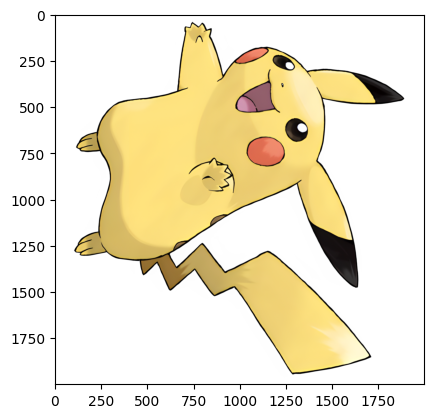


Поворот Пикачу на -80°:



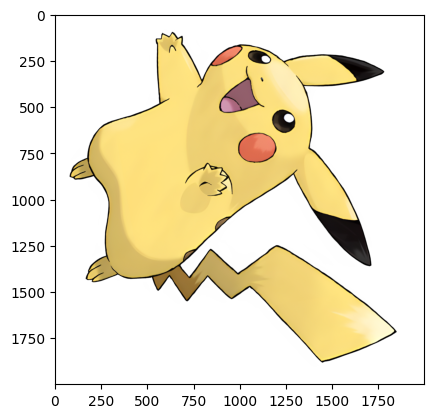


Поворот Пикачу на -70°:



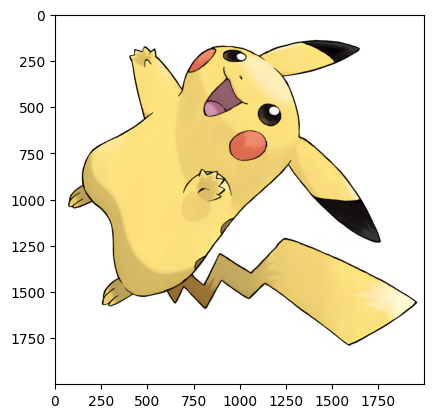


Поворот Пикачу на -60°:



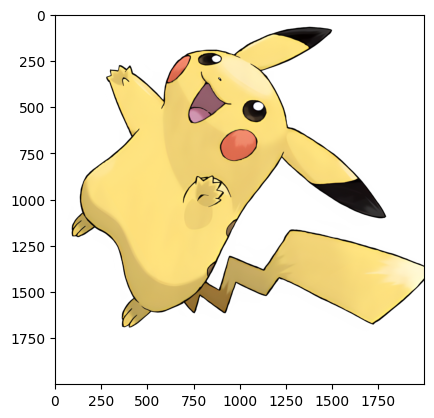


Поворот Пикачу на -50°:



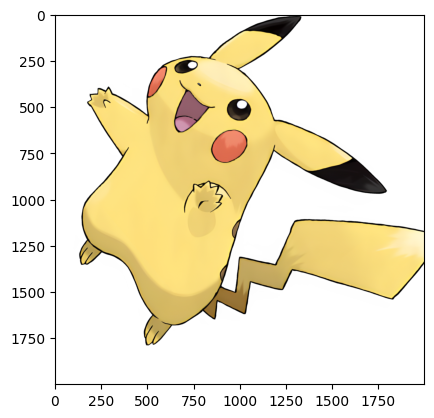


Поворот Пикачу на -40°:



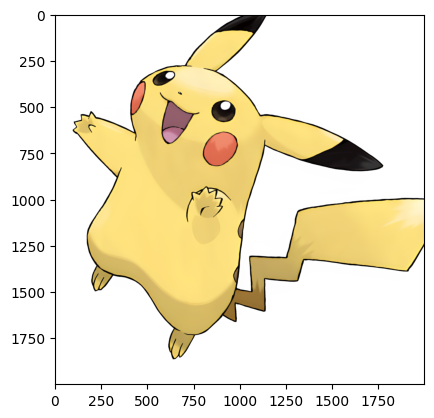


Поворот Пикачу на -30°:



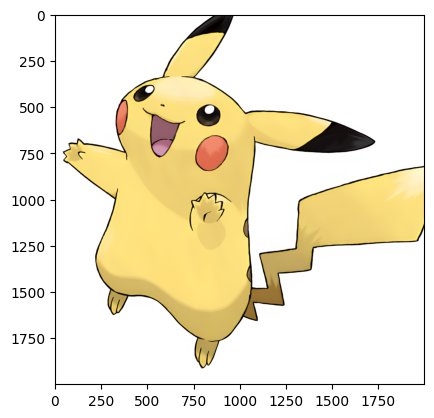


Поворот Пикачу на -20°:



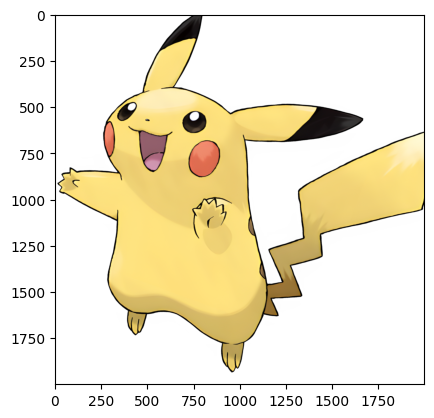


Поворот Пикачу на -10°:



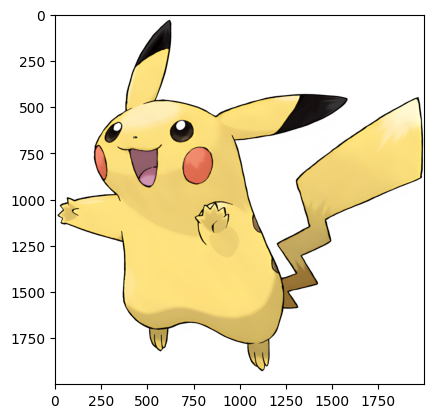


Поворот Пикачу на 0°:



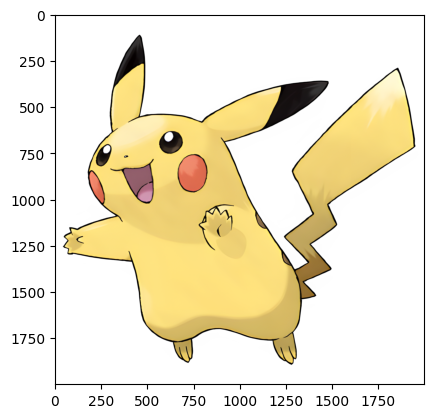


Поворот Пикачу на 10°:



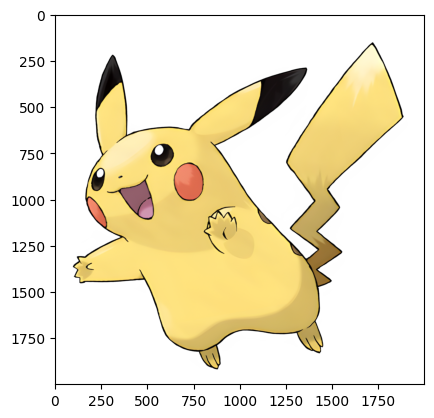


Поворот Пикачу на 20°:



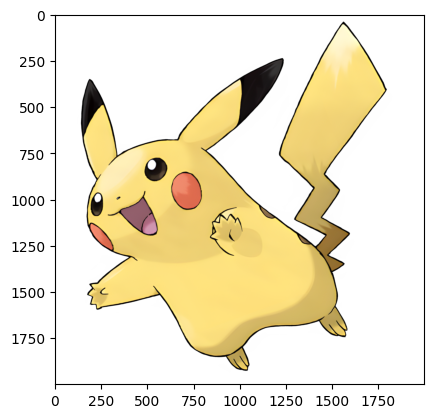


Поворот Пикачу на 30°:



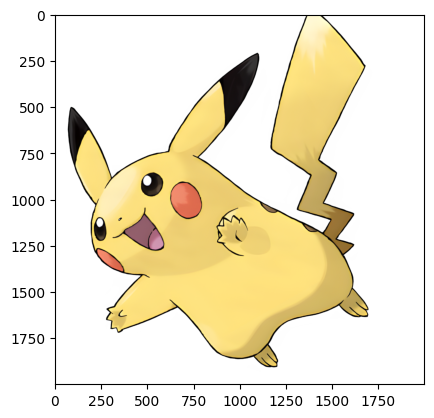


Поворот Пикачу на 40°:



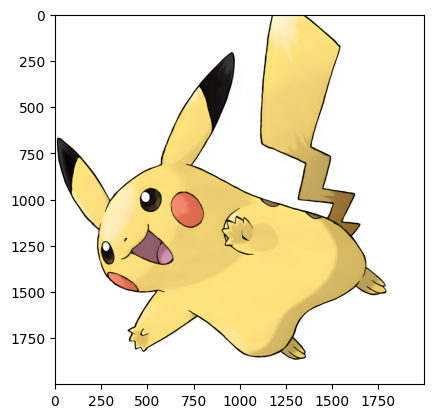


Поворот Пикачу на 50°:



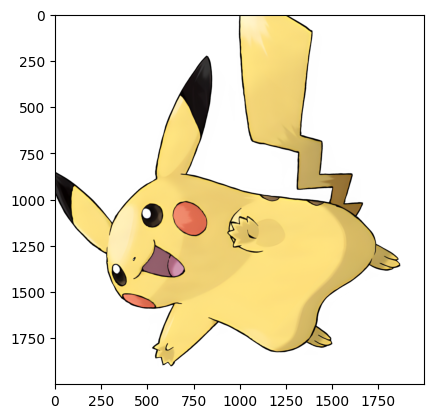


Поворот Пикачу на 60°:



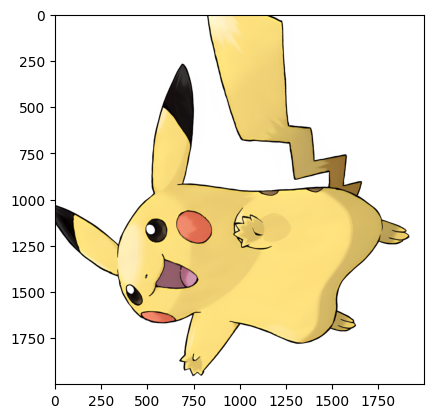


Поворот Пикачу на 70°:



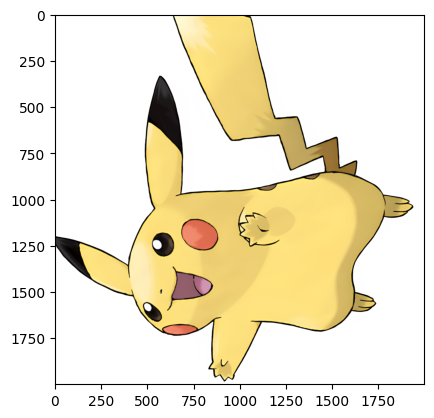


Поворот Пикачу на 80°:



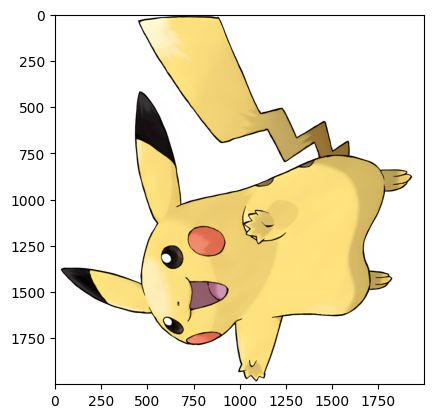


Поворот Пикачу на 90°:



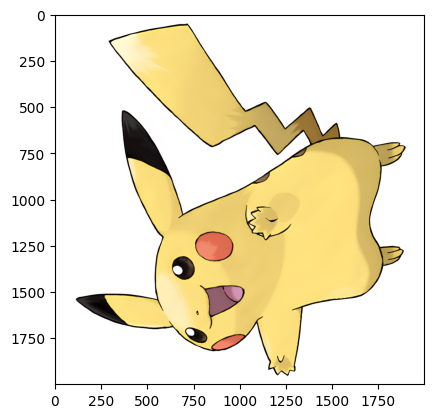

In [9]:
# Вывод изменённых изображений
for k, v in deg_img_dict.items():
    print(f"\nПоворот Пикачу на {k}°:\n")
    plt.imshow(v)
    plt.show()

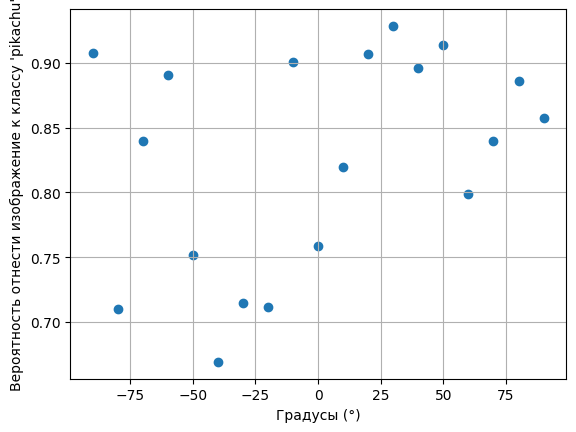

In [10]:
# Вывод графика
plt.scatter(deg_probs_dict.keys(), [v["pikachu"] for _, v in deg_probs_dict.items()])
plt.grid()
plt.xlabel("Градусы (°)")
plt.ylabel("Вероятность отнести изображение к классу 'pikachu'")
plt.show()

Вывод: В целом, поворот картинки повлиял на степень уверенности моедели в факте нахождения Пикачу на картинке, но тем менее нейросеть верно определила его наличие вне зависимости от поворота изображения. Это может быть связано с тем, что Пикачу находится в центре изображения и при повороте изображения лишь небольшая часть данных теряется.

# Изменение ширины изображения. 3.2

In [11]:
# Создание словарей для хранения данных
w_probs_dict = {}
w_img_dict = {}

In [12]:
# Изменения ширины изображений и классификация
for k in tqdm.tqdm([i / 10 for i in range(5, 21)]):
    resized_img = img.copy()
    w, h = resized_img.size
    w = round(w * k)
    resized_img = resized_img.resize((w, h), Image.Resampling.LANCZOS)
    probs = get_distribution(resized_img, classes)
    w_probs_dict[k] = dict(zip(classes, probs))
    w_img_dict[k] = resized_img

100%|██████████| 16/16 [00:13<00:00,  1.15it/s]



Изменение ширина в 0.5:



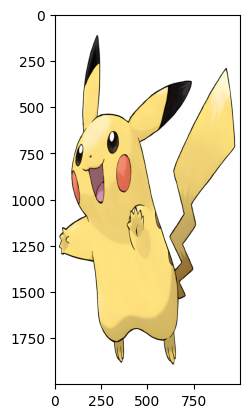


Изменение ширина в 0.6:



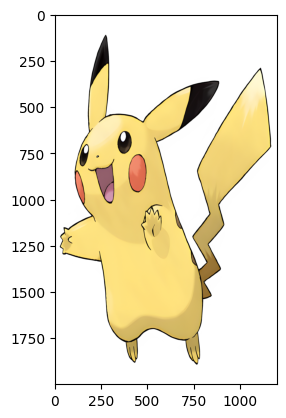


Изменение ширина в 0.7:



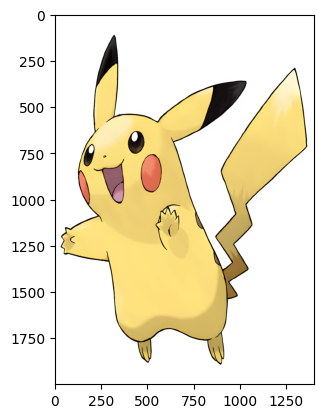


Изменение ширина в 0.8:



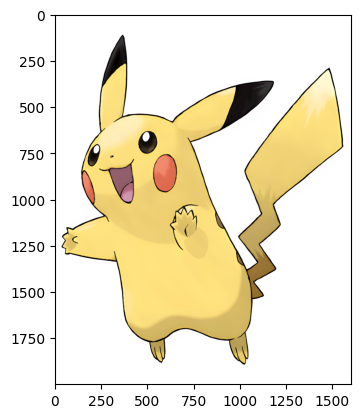


Изменение ширина в 0.9:



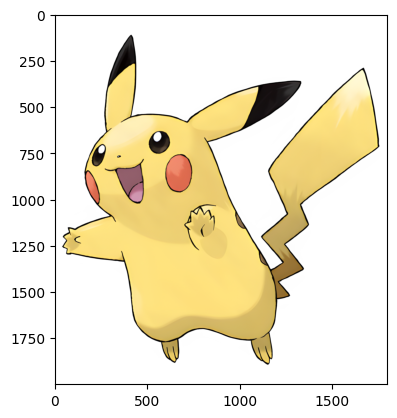


Изменение ширина в 1.0:



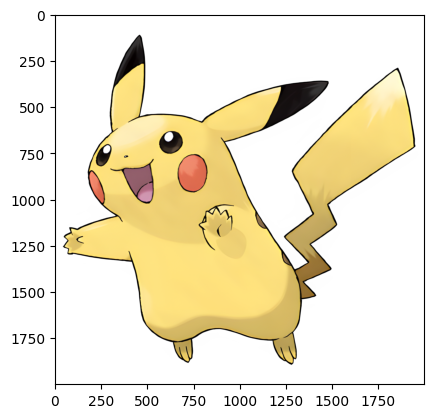


Изменение ширина в 1.1:



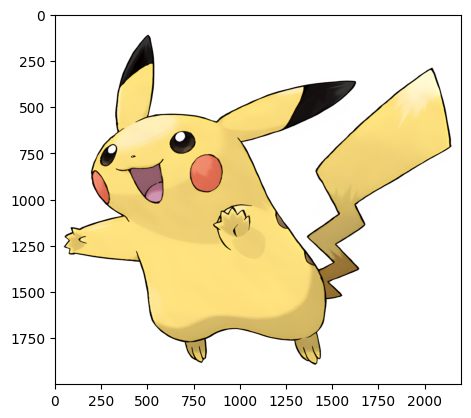


Изменение ширина в 1.2:



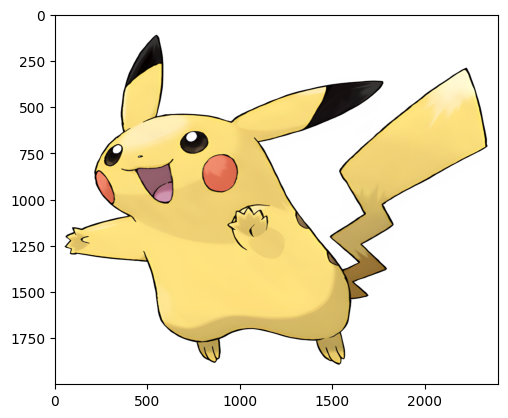


Изменение ширина в 1.3:



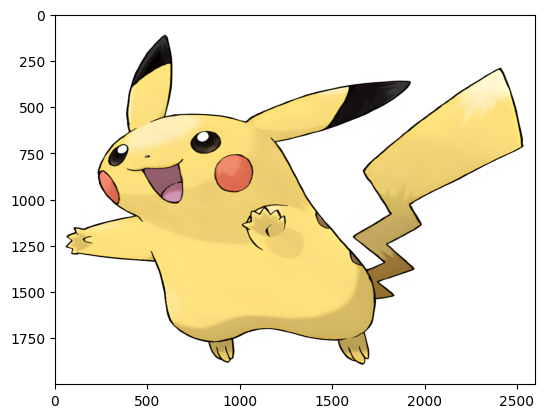


Изменение ширина в 1.4:



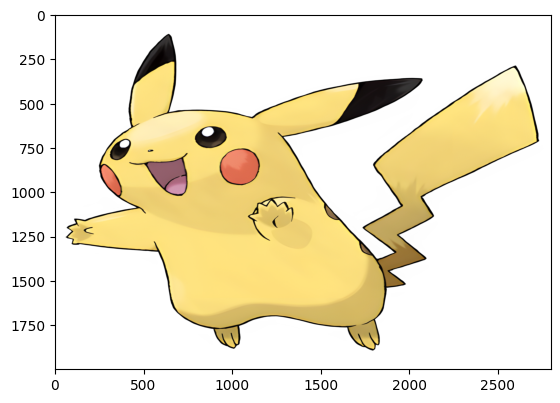


Изменение ширина в 1.5:



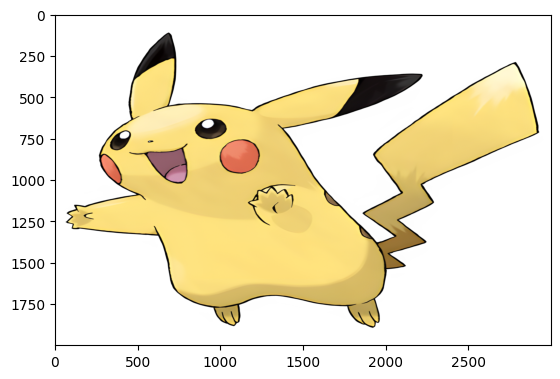


Изменение ширина в 1.6:



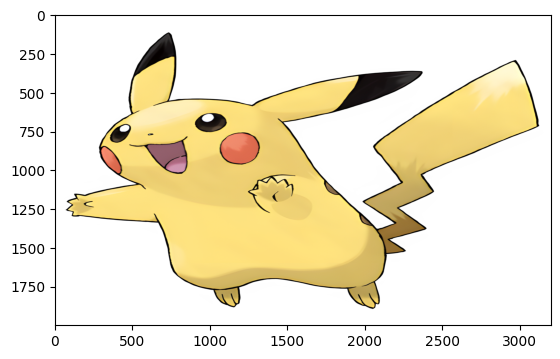


Изменение ширина в 1.7:



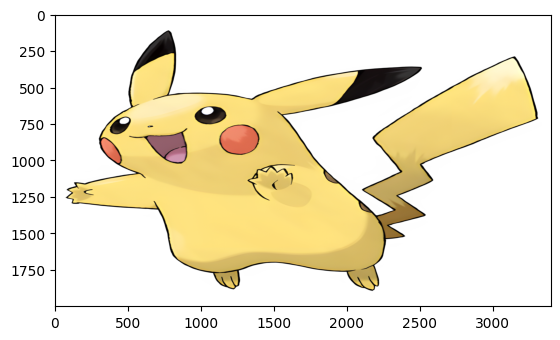


Изменение ширина в 1.8:



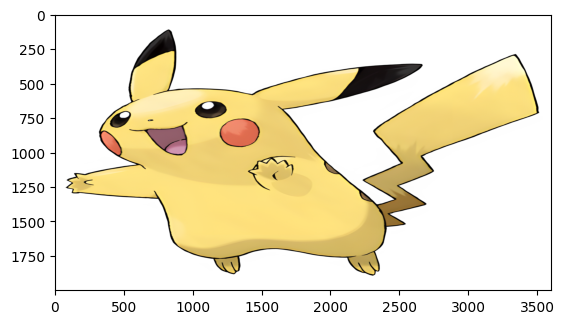


Изменение ширина в 1.9:



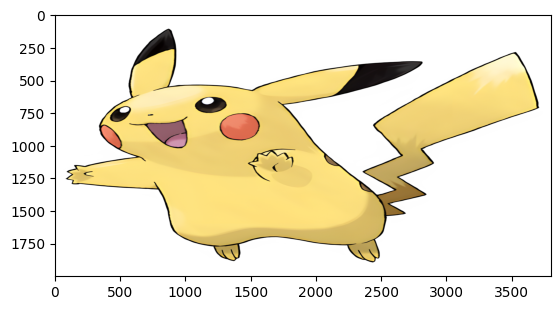


Изменение ширина в 2.0:



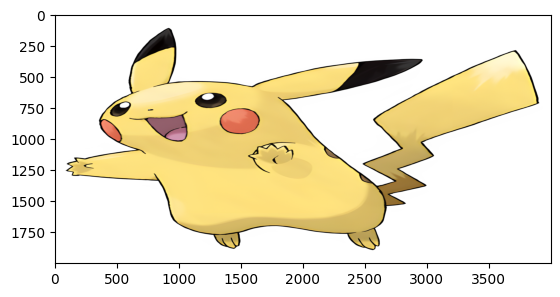

In [13]:
# Вывод изменённых изображений
for k, v in w_img_dict.items():
    print(f"\nИзменение ширина в {k}:\n")
    plt.imshow(v)
    plt.show()

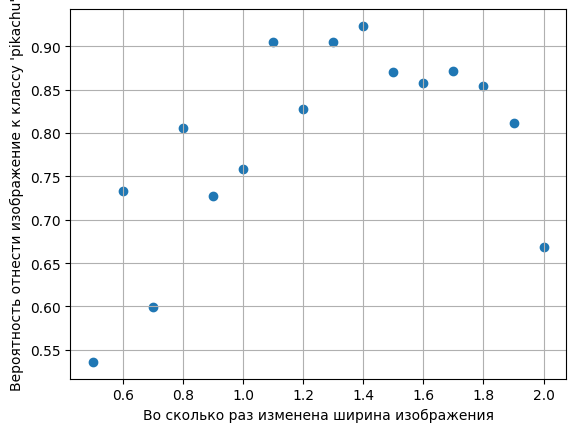

In [14]:
# Вывод графиков
plt.scatter(w_probs_dict.keys(), [v["pikachu"] for _, v in w_probs_dict.items()])
plt.grid()
plt.xlabel("Во сколько раз изменена ширина изображения")
plt.ylabel("Вероятность отнести изображение к классу 'pikachu'")
plt.show()

Вывод: В целом, вне зависимости от степени искуственного изменения ширины изображения точность предесказания не меняется, но при чрезмерном сужения картинки модель может ошибиться. Это может быть вызвано тем, что при довольно высокой степени сужения изображения теряется часть данных, что ведёт к ухудшению качества классификации.

# Изменение цветовых каналов изображения. 3.3

In [37]:
# Создание словарей для хранения данных
recomb_probs_dict = {}
recomb_img_dict = {}

In [38]:
# Разделение цветовых каналов изображения, их рекомбинация и классификация изображений
red, green, blue, alpha = img.split()
channel_dict = {
    "red": red, "green": green, "blue": blue
}

for i in tqdm.tqdm(list(itertools.permutations(["red", "green", "blue"]))):
    comb = [channel_dict[j] for j in i]
    recombined = Image.merge('RGBA', (*comb, alpha))
    probs = get_distribution(recombined, classes)
    recomb_probs_dict[", ".join(i)] = dict(zip(classes, probs))
    recomb_img_dict[", ".join(i)] = recombined

100%|██████████| 6/6 [00:06<00:00,  1.03s/it]



Комбинация каналов: red, green, blue:



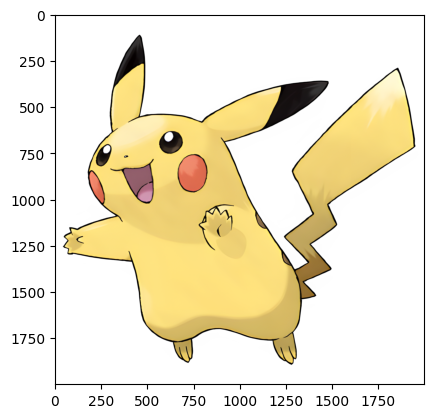


Комбинация каналов: red, blue, green:



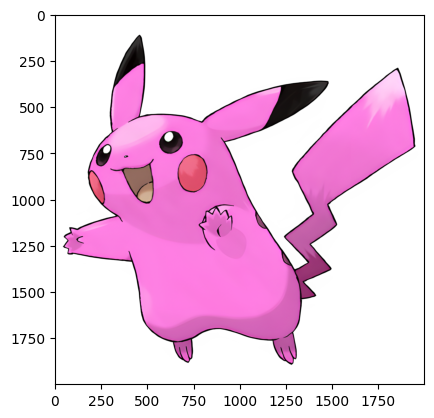


Комбинация каналов: green, red, blue:



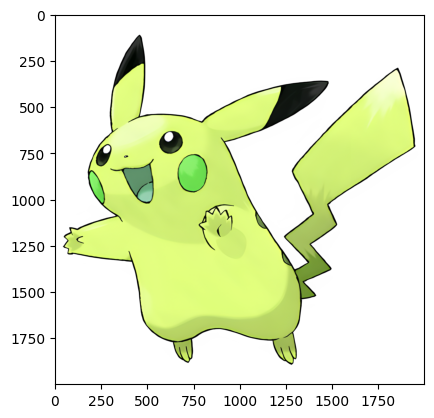


Комбинация каналов: green, blue, red:



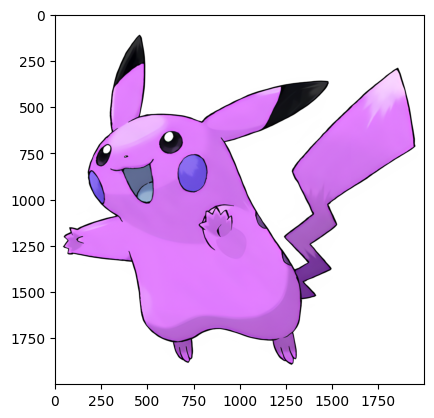


Комбинация каналов: blue, red, green:



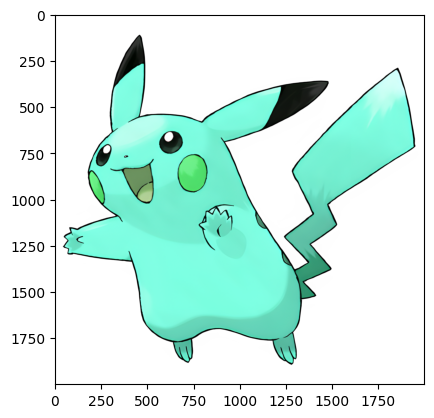


Комбинация каналов: blue, green, red:



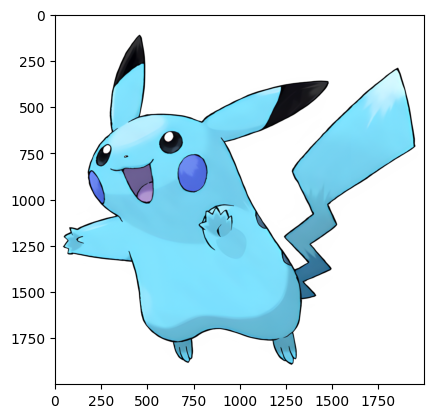

In [39]:
# Вывод изменённых изображений
for k, v in recomb_img_dict.items():
    print(f"\nКомбинация каналов: {k}:\n")
    plt.imshow(v)
    plt.show()

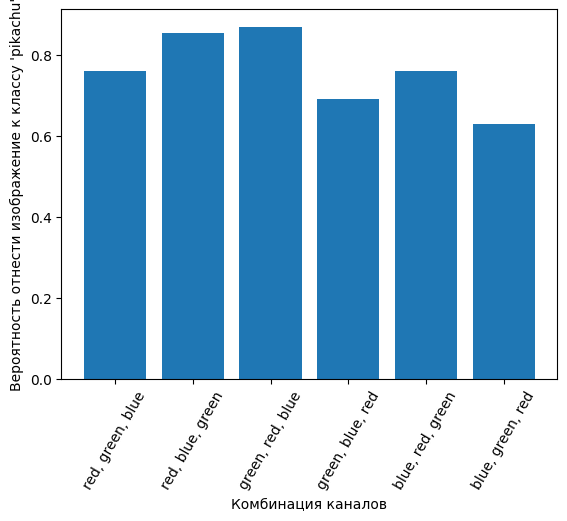

In [47]:
# Вывод графика
plt.bar(recomb_probs_dict.keys(), [v["pikachu"] for _, v in recomb_probs_dict.items()])
plt.xlabel("Комбинация каналов")
plt.ylabel("Вероятность отнести изображение к классу 'pikachu'")
plt.xticks(rotation=60)
plt.show()

Вывод: В целом, можно отметить, что перестановка цветовых каналов особо не влияет на точность классификации изображений.